------

#*Grupo3 SRL*

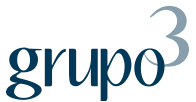




#*Representantes comerciales*

Nombre y Apellido | Legajo
------------------|---
Fernandez, Guillermo German | 1157416
Piñero, Nicolas | 1158808
Szczur, Diego | 1160772
Gamarra, Zaira | 1155371

------

#*Modelo predictivo para Retención de Clientes - Banco Camila*

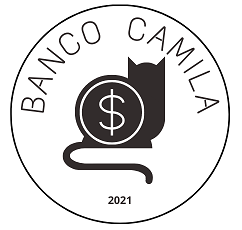

El Departamento de Marketing y Retención de Clientes de Banco Camila nos solicitó el desarrollo de un modelo predictivo para estimar aquellos clientes que tengan potencial de abandonar el Banco.

Si bien es posible identificar a aquellos clientes que podrán solicitar la baja de productos para el próximo mes respecto del momento del análisis, respetando la regla de negocio de Banco Camila, nos enfocaremos a identificar clientes con potencial de solicitar la baja dentro de dos meses. De esta forma se contará con tiempo suficiente para poder enviar un paquete de beneficios adicionales al cliente identificado y así evitar su futura baja.

Los datos analizados para el entrenamiento de este modelo corresponden al año 2014, y en particular a los meses de Febrero, Marzo y Abril, ya que son los datos más actuales dentro del dataset que nos brindó el cliente. 

Conociendo a los clientes que estuvieron activos en Febrero y Marzo de 2014, pero que luego se dieron de baja en el mes de Abril 2014, estudiaremos su comportamiento con diferentes variables crediticias para clasificarlos en dos clases:

- Clase 0: cliente que continua activo.
- Clase 1: cliente con potencial de baja.

De esta forma procedemos a realizar dicha clasificación con diferntes modelos predictivos de aprendizaje supervisado para lograr la mayor cantidad de clientes retenidos y la mayor ganancia posible por parte del banco.

------

#Herramientas a utilizar

A continuación se detallan las herramientas utilizadas, lo cual incluye diferentes librerías para la carga, limpieza y tranformación de los datos proporcionados, así como librerías específicas para generar los diferentes modelos predictivos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectPercentile, RFECV, f_regression

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


------


#Funciones auxiliares



Definimos funciones auxiliares que usaremos en distintas partes del análisis.

*printmetricas()*: calcula las métricas sobre las predicciónes obtenidas en determinado modelo. Retorna un diccionario con dichas métricas.

In [3]:
#Evaluación de métricas.
def printmetricas(Ytest, YPred, DfPred, Algoritmo):
  print('---------- Test: Accuracy ----------')
  print(accuracy_score(Ytest, YPred))
  print('---------- Test: Recall ----------')
  print(recall_score(Ytest, YPred))
  print('---------- Test: Precision ----------')
  print(precision_score(Ytest, YPred))
  print('--------- Confusion Matrix ---------')
  print(confusion_matrix(Ytest, YPred))
  print('-------------------------------')
  print('Máximo posible de Ganancia: ', DfPred.cum_profit.max())
  print('Total de Ganancia Real: ', DfPred.profit.sum())

  valor = DfPred.cum_profit.max()
  probabilidad = DfPred[DfPred['cum_profit'] == valor]
  
  return {
      'Algoritmo': str(Algoritmo),
      'Accuracy': accuracy_score(Ytest, YPred),
      'Recall': recall_score(Ytest, YPred),
      'Precision': precision_score(Ytest, YPred),
      'True Positive': confusion_matrix(Ytest, YPred)[0,0],
      'False Positive': confusion_matrix(Ytest, YPred)[0,1],
      'False Negative': confusion_matrix(Ytest, YPred)[1,0],
      'True Negative': confusion_matrix(Ytest, YPred)[1,1],
      'Predict Max': DfPred.cum_profit.max(),
      'Predict Sum': DfPred.profit.sum(),
      'Proba de Corte': round(probabilidad.prob_a.max(), 3)
  }

*plotCurvaRoc()*: calcula y grafica la curva ROC sobre las predicciones obtenidas en determinado modelo. Retorna un diccionario al que se le adiciona la métrica calculada.

In [4]:
#Evaluación de la curva ROC.
def plotCurvaRoc(Ytest, Yprobability,Algoritmo, dictMetricas):
  print('--------- Curva ROC Score ---------')
  print(roc_auc_score(Ytest, Yprobability))
  false_positive_rate, true_positive_rate, threshold = roc_curve(Ytest, Yprobability)
  #Curva ROC.
  plt.subplots(1, figsize=(10,10))
  plt.title('Receiver Operating Characteristic - '+ str(Algoritmo))
  plt.plot(false_positive_rate, true_positive_rate)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"),
  plt.plot([1, 1] , c=".7")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  dictMetricas['ROC'] = roc_auc_score(Ytest, Yprobability)
  return dictMetricas

*GuardarMetricasCSV()*: almacena en formato CSV los resultados de un modelo predictivo, donde se le calcula el costo de acción por cliente y la sumatoria total del mismo.

In [5]:
def GuardarMetricasCSV(df_param, Algoritmo):
  df_param['profit'] = df_param['y_pred'] * (-100) + df_param['y_pred'] * df_param['y_test'] * 5000
  df_param = df_param.sort_values(by = ['prob_a'], ascending = False)
  df_param['cum_profit'] = df_param.profit.cumsum()
  df_param.to_csv(r''+ Algoritmo + '.csv')
  return df_param

-------

#Carga de datos

El dataset proporcionado por el cliente se encuentra almacenado en un archivo comprimido (MESES_hasta_201404.zip). El mismo es cargado en un dataset, pero para no consumir demasiada memoria en la ejecución del notebook, almacenamos los datos en formato Parquet. Para hacerlo fue necesario convertir el tipo de dato de algunas columnas.

Los siguientes bloques de código se encuentran comentados ya que fueron ejecutados solo una vez, y luego de eso siempre se utilizará el nuevo archivo generado.


In [6]:
#Levantamos el archivo zip para generar un dataframe con la data cruda.

#path_file = "/content/drive/MyDrive/Colab Notebooks/Bimestre3/MESES_hasta_201404.zip"
#data_cruda = pd.read_csv(path_file)
#data_cruda

In [7]:
##Mixed data types issues, por lo tanto hacemos conversiones.

#data_cruda['marketing_activo_ultimos90dias'] = data_cruda['marketing_activo_ultimos90dias'].astype(str)
#data_cruda['mprestamos_hipotecarios'] = data_cruda['mprestamos_hipotecarios'].astype(str)
#data_cruda['mtarjeta_visa_descuentos'] = data_cruda['mtarjeta_visa_descuentos'].astype(str)
#data_cruda['mtarjeta_master_descuentos'] = data_cruda['mtarjeta_master_descuentos'].astype(str)

#Guardamos en formato Parquet.
#data_cruda.to_parquet('/content/drive/MyDrive/Colab Notebooks/Bimestre3/MESES_hasta_201404.parquet')

Una vez hecha la conversión de formato del archivo de entrada, lo importamos y generamos el dataframe que utilizaremos en adelante. El mismo cuenta con un total de:
- 2694630 registros
- 169 variables

In [6]:
#Cargamos el nuevo archivo.
data_cruda = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Bimestre3/MESES_hasta_201404.parquet')
data_cruda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694630 entries, 0 to 2694629
Columns: 169 entries, numero_de_cliente to Visa_mpagominimo
dtypes: float64(41), int64(38), object(90)
memory usage: 3.4+ GB


-------

#Limpieza y transformación de datos

###Limpieza inicial

El primer filtrado que haremos de los datos consiste en capturar los regitros cuyo valor de *foto_mes* es mayor a Enero de 2014 (201401). Como resultado obtendremos unicamente valores para los meses de interés:
*   Febrero 2014 (201402)
*   Marzo 2014 (201403)
*   Abril 2014 (201404)

De esta forma redujimos la cantidad de registros a 549863.

In [7]:
#Filtrado de fecha.
data_filtro_fecha = data_cruda[data_cruda.foto_mes > 201401]
data_filtro_fecha.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549863 entries, 5 to 2694629
Columns: 169 entries, numero_de_cliente to Visa_mpagominimo
dtypes: float64(41), int64(38), object(90)
memory usage: 713.2+ MB


Dado que la data de meses anteriores ya no es revelante, eliminamos la información para liberar memoria y favorecer la ejecución del notebook.

In [8]:
data_cruda = 0

In [9]:
data_filtro_fecha.head(1)

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
5,3333,201403,.,0,455,0,0,16109631.53,-125363120.5,2362829.57,...,.,.,.,.,.,.,.,S,S,.


Continuamos con la exploración de registros duplicados, y su eventual eliminación del dataset.

In [10]:
#Análisis de duplicados.
data_filtro_fecha_T = data_filtro_fecha.groupby(['numero_de_cliente','foto_mes'])['numero_de_cliente'].count().reset_index(name='count')  
data_filtro_fecha_T[data_filtro_fecha_T['count']>1]

,numero_de_cliente,foto_mes,count
0,3333,201403,2
1,3333,201404,2


In [11]:
#Eliminación de duplicados.
data_filtro_fecha = data_filtro_fecha[data_filtro_fecha['numero_de_cliente'] != 3333]

###Generación de la variable objetivo

El próximo paso consiste en la construcción de la variable objetivo "target_bin" que indica con 0 y 1, según las clases definidas anteriormente, si el cliente tiene potencial de solicitar la baja. Para esto generamos una serie de columnas auxiliares y temporales que nos ayudan a calcular dicha variable.

Identificamos a los clientes de la siguiente forma:
- "Continúa" es un cliente activo en los tres meses de análisis (201402, 201403 y 201404)
- "Baja+1" es un cliente que solo esta activo en el primer mes (201402), y ya no lo está en el segundo ni tercer mes (201403 y 201404 respectivamente).
- "Baja+2" es un cliente que está activo en los dos primeros meses (201402 y 201403) y no lo está en el tercer mes (201404).

Con estas clases provisorias, la variables "tarjet_bin" se construye de la siguiente manera:
- "Continúa" y "Baja+1" catalogan para la clase 0.
- "Baja+2" cataloga para la clase 1.

Una vez generada esta variable objetivo, filtramos nuevamente los datos para capturar aquellos donde *foto_mes* tenga el valor del mes con el cual entrenaremos los modelos predictivos: en este caso, 201402.

Identificamos con este filtro 181981 registros, de los cuales 773 se clasifican como 1, y 181208 se clasifican como 0.

In [12]:
#Generacion de columnas con informacion de mes+1 y mes+2.
data_filtro_fecha['Mes_1'] = data_filtro_fecha.groupby(['numero_de_cliente'])['foto_mes'].shift(-1)
data_filtro_fecha['Mes_2'] = data_filtro_fecha.groupby(['numero_de_cliente'])['foto_mes'].shift(-2)

#Eliminacion de los registros con fecha > a 201402.
data_filtro_fecha = data_filtro_fecha[data_filtro_fecha.foto_mes == 201402]

data_filtro_fecha.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181981 entries, 22 to 2694499
Columns: 171 entries, numero_de_cliente to Mes_2
dtypes: float64(43), int64(38), object(90)
memory usage: 238.8+ MB


In [13]:
#Generacion de columnas target como clase y binaria.
data_filtro_fecha['target'] = "Baja+1"
data_filtro_fecha.loc[(data_filtro_fecha['Mes_1']==201403), 'target'] = "Baja+2"
data_filtro_fecha.loc[(data_filtro_fecha['Mes_2']==201404), 'target'] = "Continua"
data_filtro_fecha['target_bin'] = np.where(data_filtro_fecha['target']=='Baja+2', 1, 0)

data_filtro_fecha['target_bin'].value_counts()

0    181208
1       773
Name: target_bin, dtype: int64

In [14]:
#Eliminacion de las columnas auxiliares temporales.
data_filtro_fecha = data_filtro_fecha.drop(['Mes_1' , 'Mes_2', 'target'] , axis = 'columns')

### Limpieza de variables irrelevantes
A continuación eliminamos todas aquellas variables del dataset que poseen el mismo valor para todos los registros. Esto se debe a que no agregarán valor al análisis predictivo dado que no presentan varianza.

In [15]:
Dict={}

#Recorremos el dataset y generamos un diccionario con la cantidad de valores posibles por columna.
for column in data_filtro_fecha.columns:
     case = data_filtro_fecha[column].nunique() 
     Dict[column]=case

#Eliminamos columnas que poseen un unico valor posible.
filtered_dict_1 = {k:v for k,v in Dict.items() if v<=1 }

for k,y in filtered_dict_1.items():
  del data_filtro_fecha[k]

data_filtro_fecha.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181981 entries, 22 to 2694499
Data columns (total 146 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    numero_de_cliente                 int64  
 1    cliente_vip                       int64  
 2    cliente_sucursal                  int64  
 3    cliente_edad                      int64  
 4    cliente_antiguedad                int64  
 5    mrentabilidad                     float64
 6    mrentabilidad_annual              float64
 7    marketing_coss_selling            int64  
 8    tpaquete2                         object 
 9    tpaquete4                         object 
 10   tpaquete6                         object 
 11   tpaquete7                         object 
 12   tpaquete9                         object 
 13   tcuentas                          object 
 14   tcuenta_corriente                 object 
 15   mcuenta_corriente_Nopaquete       float64
 16   mcuenta_corrient

Guardamos el listado de variables para que, una vez definido el modelo predictivo final, podamos filtrar futuros datasets. 

In [16]:
variables_mandatorias = list(data_filtro_fecha.columns)
variables_mandatorias.remove('target_bin')
variables_mandatorias.append('foto_mes')

Procedemos con la eliminación de columnas que consideramos de poco valor para el análisis. 
- Columnas con información de fecha
- Número de cliente

In [17]:
columnas_del = ['numero_de_cliente', 'Master_Fvencimiento', 'Master_fultimo_cierre', 'Master_fechaalta', 'Visa_Fvencimiento', 'Visa_fultimo_cierre', 'Visa_fechaalta']
data_filtro_fecha.drop(columns = columnas_del, axis = 1, inplace = True)
data_filtro_fecha.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181981 entries, 22 to 2694499
Data columns (total 139 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    cliente_vip                       int64  
 1    cliente_sucursal                  int64  
 2    cliente_edad                      int64  
 3    cliente_antiguedad                int64  
 4    mrentabilidad                     float64
 5    mrentabilidad_annual              float64
 6    marketing_coss_selling            int64  
 7    tpaquete2                         object 
 8    tpaquete4                         object 
 9    tpaquete6                         object 
 10   tpaquete7                         object 
 11   tpaquete9                         object 
 12   tcuentas                          object 
 13   tcuenta_corriente                 object 
 14   mcuenta_corriente_Nopaquete       float64
 15   mcuenta_corriente_Paquete         float64
 16   tcaja_ahorro    

###Transformación de valores y tipos
Reemplazamos los valores incorrectos ('.') presentes en el dataset. El criterio utilizado es:
- Variables de tipo object-booleano reemplamos por -1 y transformamos a tipo INT
- Variables de tipo object-numérico reemplamos por 0 y transformamos a tipo FLOAT.

In [18]:
# ' por -1, y tipo INT
data_filtro_fecha['Visa_marca_atraso'] = data_filtro_fecha['Visa_marca_atraso'].replace('.', -1).astype(int)
data_filtro_fecha['Master_marca_atraso'] = data_filtro_fecha['Master_marca_atraso'].replace('.', -1).astype(int)

In [19]:
# . por 0, y tipo FLOAT
columnas_float = ['mprestamos_hipotecarios', 'mcuenta_debitos_automaticos', 'mttarjeta_visa_debitos_automatic', 'mttarjeta_master_debitos_automat', 'mpagodeservicios',
'mpagomiscuentas', 'mtarjeta_visa_descuentos', 'mtarjeta_master_descuentos', 'Master_mfinanciacion_limite', 'Master_msaldototal', 'Master_msaldopesos', 'Master_msaldodolares',
'Master_mconsumospesos', 'Master_mconsumosdolares', 'Master_mlimitecompra', 'Master_madelantopesos', 'Master_madelantodolares', 'Master_mpagado', 'Master_mpagospesos', 'Master_mpagosdolares',
'Master_mconsumototal', 'Master_mpagominimo', 'Visa_mfinanciacion_limite', 'Visa_msaldototal', 'Visa_msaldopesos', 'Visa_msaldodolares', 'Visa_mconsumospesos', 'Visa_mconsumosdolares', 
'Visa_mlimitecompra', 'Visa_madelantopesos', 'Visa_madelantodolares', 'Visa_mpagado', 'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_mconsumototal', 'Visa_mpagominimo']

for col in columnas_float:
  data_filtro_fecha[col] = data_filtro_fecha[col].replace('.', 0).astype(float)

###Transformación de variables categóricas

Procedemos con la transformación de aquellas variables con valores categóricos a valores numéricos con el método de *get_dummies()*.
*   Para las variables con más de dos valores posibles, se quito la columa original y se adicionaron tantas columnas nuevas como valores existen.
*   Para las variables con solo dos valores posibles, se quito la columna original y se adiciono unicamente la columa con el valor 'S'.


In [20]:
#Variables con más de dos posibles valores.
data_filtro_fecha = pd.get_dummies(data_filtro_fecha, columns = ['Master_cuenta_estado', 'Visa_cuenta_estado'])

In [21]:
#Variables con solo dos valores posibles.
columnas_dummies = ['tpaquete2', 'tpaquete4', 'tpaquete6', 'tpaquete7', 'tpaquete9', 'tcuentas', 'tcuenta_corriente', 'tcaja_ahorro', 'ttarjeta_debito', 'ttarjeta_visa', 
'ttarjeta_master', 'tplazo_fijo', 'tfondos_comunes_inversion', 'ttitulos', 'tseguro_vida_mercado_abierto', 'tseguro_auto', 'tseguro_vivienda', 'tseguro_accidentes_personales', 
'tcaja_seguridad',  'tcuenta_debitos_automaticos', 'ttarjeta_visa_debitos_automatico', 'ttarjeta_master_debitos_automati', 'tpagodeservicios','tpagomiscuentas', 'tcambio_monedas', 
'tcallcenter',  'tcajas', 'tcajas_depositos', 'tcajas_extracciones', 'tcajas_otras', 'tmovimientos_ultimos90dias', 'Master_tconsumos', 'Master_tadelantosefectivo', 
'Visa_tconsumos', 'Visa_tadelantosefectivo']

data_filtro_fecha = pd.get_dummies(data_filtro_fecha, columns = columnas_dummies, drop_first = True)
data_filtro_fecha.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181981 entries, 22 to 2694499
Data columns (total 147 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    cliente_vip                         int64  
 1    cliente_sucursal                    int64  
 2    cliente_edad                        int64  
 3    cliente_antiguedad                  int64  
 4    mrentabilidad                       float64
 5    mrentabilidad_annual                float64
 6    marketing_coss_selling              int64  
 7    mcuenta_corriente_Nopaquete         float64
 8    mcuenta_corriente_Paquete           float64
 9    mcaja_ahorro_Paquete                float64
 10   mcaja_ahorro_Nopaquete              float64
 11   mcaja_ahorro_dolares                float64
 12   mdescubierto_preacordado            float64
 13   mcuentas_saldo                      float64
 14   ctarjeta_debito_transacciones       int64  
 15   mautoservicio                 

###Tratamiento de valores nulos

Realizamos el reemplazo de valores nulos por 0 en caso que hayan quedado en el dataset.

In [22]:
data_filtro_fecha = data_filtro_fecha.fillna(0)

###Variables calculadas


Continuamos con el cálculo de variables adicionales para enriquecer el dataset.

In [23]:
#Variables calculadas
data_filtro_fecha['mcuenta_corriente_all'] = data_filtro_fecha['mcuenta_corriente_Paquete'] + data_filtro_fecha['mcuenta_corriente_Nopaquete']
data_filtro_fecha['mcaja_ahorro_all'] = data_filtro_fecha['mcaja_ahorro_Paquete'] + data_filtro_fecha['mcaja_ahorro_Nopaquete']
data_filtro_fecha['mcaja_ahorro_CC'] = data_filtro_fecha['mcaja_ahorro_all'] + data_filtro_fecha['mcuenta_corriente_all']
data_filtro_fecha['mtarjeta_all_consumo'] = data_filtro_fecha['mtarjeta_visa_consumo'] + data_filtro_fecha['mtarjeta_master_consumo']
data_filtro_fecha['ctarjeta_all_transacciones'] = data_filtro_fecha['ctarjeta_visa_transacciones'] + data_filtro_fecha['ctarjeta_master_transacciones']

In [24]:
data_filtro_fecha.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181981 entries, 22 to 2694499
Data columns (total 152 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    cliente_vip                         int64  
 1    cliente_sucursal                    int64  
 2    cliente_edad                        int64  
 3    cliente_antiguedad                  int64  
 4    mrentabilidad                       float64
 5    mrentabilidad_annual                float64
 6    marketing_coss_selling              int64  
 7    mcuenta_corriente_Nopaquete         float64
 8    mcuenta_corriente_Paquete           float64
 9    mcaja_ahorro_Paquete                float64
 10   mcaja_ahorro_Nopaquete              float64
 11   mcaja_ahorro_dolares                float64
 12   mdescubierto_preacordado            float64
 13   mcuentas_saldo                      float64
 14   ctarjeta_debito_transacciones       int64  
 15   mautoservicio                 

Una vez terminada la limpieza y transformación de variables, estamos en condiciones de pasar al entrenamieto de los modelos. 


---------

#Separación en Train y Test

Previo al entrenamiento de los modelos, realizamos la separación de los datos diferenciando entre las variables independientes (X_total) y la variable objetivo (y_total).

A su vez graficamos la distribución de la variable objetivo para ver la frecuencia de las clases.

Text(0, 0.5, 'Cantidad de Observaciones')

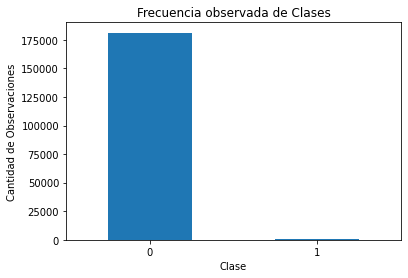

In [25]:
#Separación.
X_total = data_filtro_fecha.drop(['target_bin'] , axis = 'columns')
y_total = data_filtro_fecha.target_bin

#Ploteo.
count_classes = pd.value_counts(y_total, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frecuencia observada de Clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Observaciones")

Realizamos la separación de los datos en los conjuntos TRAIN y TEST.

In [26]:
# Particion de datos externa: conjutos de TRAIN y TEST.
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.25, random_state = 42)

print('---------- X_train ---------- ')
print(np.shape(X_train))
print('----------- X_test ---------- ')
print(np.shape(X_test))
print('---------- y_train ---------- ')
print(np.shape(y_train))
print('---------- y_test ---------- ')
print(np.shape(y_test))

---------- X_train ---------- 
(136485, 151)
----------- X_test ---------- 
(45496, 151)
---------- y_train ---------- 
(136485,)
---------- y_test ---------- 
(45496,)


Verificamos la distribución de clases tanto en el conjunto de train como en el de test. 

In [27]:
print('---------- y_train ---------- ')
print('Cantidad de 0 :', (y_train == 0).sum())
print('Cantidad de 1 :', (y_train == 1).sum())
print('---------- y_test ---------- ')
print('Cantidad de 0 :', (y_test == 0).sum())
print('Cantidad de 1 :', (y_test == 1).sum())

---------- y_train ---------- 
Cantidad de 0 : 135895
Cantidad de 1 : 590
---------- y_test ---------- 
Cantidad de 0 : 45313
Cantidad de 1 : 183


Podemos observar que el dataset se encuentra muy desbalanceado en cuanto a la cantidad de clase 0 y clase 1. Por lo tanto, analizaremos modelos balanceados como no balanceados para ver su influencia en las predicciones.

-------

#Modelo 1: Regresión Logística




## Entrenamiento


###Estandarización

Escogimos el método de *StandarScaler()* para hacer la estandarización de los datos del conjunto TRAIN.

In [28]:
#Estandarizacion de las caracteristicas.
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

print('---------- X_train_std ---------- ')
print(np.shape(X_train_std))

---------- X_train_std ---------- 
(136485, 151)


###Selección de Variables

Para hacer la selección de características procedimos a utilizar el método *SelectPercentile()* con un percentil de 90 sobre los datos estandarizados del conjunto TRAIN y obtuvimos un total de 135 variables independientes.


In [29]:
# Seleccion de caracteristicas.
sel = SelectPercentile(f_regression, percentile = 90)
X_train_nf = sel.fit_transform(X_train_std, y_train)

print('---------- X_train_nf ---------- ')
print(np.shape(X_train_nf))

---------- X_train_nf ---------- 
(136485, 135)


###Modelado

Realizamos una validación cruzada de los datos de TRAIN para luego entrenar la regresión logística.

In [30]:
#Entrenamiento con validacion cruzada.
lreg = LogisticRegression(penalty = 'l1', max_iter = 500, solver = 'saga', random_state = 42, multi_class = 'ovr')

resultados = cross_val_score(lreg, X_train_nf , y_train, cv = KFold(n_splits = 5, shuffle = True, random_state = 42))
print('Accuracy:  %0.4f +/- %0.4f' % (resultados.mean(), resultados.std()))

RL_modelo_basico = lreg.fit(X_train_nf, y_train)

Accuracy:  0.9956 +/- 0.0002


## Predicción

###Estandarización

Volvemos a utilizar *StandarScaler()* para hacer ahora la estandarización de los datos del conjunto TEST.

In [31]:
#Estandarizacion de las caracteristicas de test.
X_test_std = std.transform(X_test)

print('---------- X_test_std ---------- ')
print(np.shape(X_test_std))

---------- X_test_std ---------- 
(45496, 151)


###Selección de Variables

Volvemos a utilizar *SelectPercentile()* para hacer la selección de características sobre los datos estandarizados del conjunto TEST.

In [32]:
#Selección de las caracteristicas relevantes del test.
X_test_nf = sel.transform(X_test_std)

print('---------- X_test_nf ---------- ')
print(np.shape(X_test_nf))

---------- X_test_nf ---------- 
(45496, 135)


###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [33]:
# Prediccion del conjunto test
y_pred = RL_modelo_basico.predict(X_test_nf)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 0 0 ... 0 0 0]
Cantidad de 0:  45480
Cantidad de 1:  16


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [34]:
# Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = RL_modelo_basico.predict_proba(X_test_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/RegresionLogistica')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [35]:
#Evaluación de métricas.
metricas_regresionlog = printmetricas(y_test, y_pred, df_pred, 'Regresion Logistica')

---------- Test: Accuracy ----------
0.9959337084578864
---------- Test: Recall ----------
0.03825136612021858
---------- Test: Precision ----------
0.4375
--------- Confusion Matrix ---------
[[45304     9]
 [  176     7]]
-------------------------------
Máximo posible de Ganancia:  33400
Total de Ganancia Real:  33400


--------- Curva ROC Score ---------
0.914160510035902


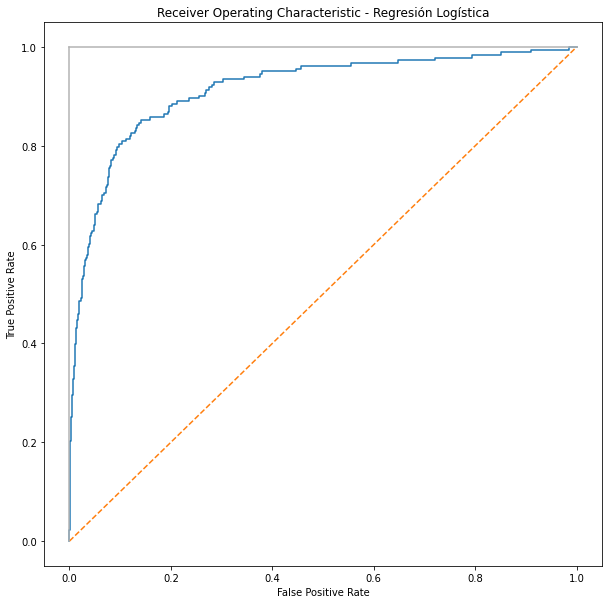

In [36]:
#Evaluación de la curva ROC.
metricas_regresionlog = plotCurvaRoc(y_test, y_probability, 'Regresión Logística', metricas_regresionlog)

In [37]:
metricas_regresionlog

{'Algoritmo': 'Regresion Logistica',
 'Accuracy': 0.9959337084578864,
 'Recall': 0.03825136612021858,
 'Precision': 0.4375,
 'True Positive': 45304,
 'False Positive': 9,
 'False Negative': 176,
 'True Negative': 7,
 'Predict Max': 33400,
 'Predict Sum': 33400,
 'Proba de Corte': 0.502,
 'ROC': 0.914160510035902}

--------------

#Modelo 2: Regresión Logística - balanceada

## Entrenamiento

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_train_std = std.fit_transform(X_train)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:

```
X_train_nf = sel.fit_transform(X_train_std, y_train))
```

###Modelado

Realizamos una validación cruzada de los datos de TRAIN para luego entrenar la regresión logística balanceada.

In [38]:
#Entrenamiento y validación cruzada.
lreg_balanced = LogisticRegression(penalty = 'l1', max_iter = 500, solver = 'saga', random_state = 42, multi_class = 'ovr', class_weight = 'balanced')

resultados = cross_val_score(lreg_balanced, X_train_nf , y_train, cv = KFold(n_splits = 5, shuffle = True, random_state = 42))
print('Accuracy:  %0.4f +/- %0.4f' % (resultados.mean(), resultados.std()))

RL_modelo_balanceado = lreg_balanced.fit(X_train_nf, y_train)

Accuracy:  0.8707 +/- 0.0027


## Predicción

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_std = std.transform(X_test)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_nf = sel.transform(X_test_std)
```

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [39]:
# Prediccion del conjunto test
y_pred = RL_modelo_balanceado.predict(X_test_nf)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 1 1 ... 0 0 1]
Cantidad de 0:  39506
Cantidad de 1:  5990


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [40]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = RL_modelo_balanceado.predict_proba(X_test_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/RegresionLogistica-balanceada')

###Evalución del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [41]:
#Evaluación de métricas.
metricas_regresionlogBAL = printmetricas(y_test, y_pred, df_pred, 'Regresion Logistica Balanceada')

---------- Test: Accuracy ----------
0.8706479690522244
---------- Test: Recall ----------
0.7868852459016393
---------- Test: Precision ----------
0.024040066777963272
--------- Confusion Matrix ---------
[[39467  5846]
 [   39   144]]
-------------------------------
Máximo posible de Ganancia:  367600
Total de Ganancia Real:  121000


--------- Curva ROC Score ---------
0.905625100168482


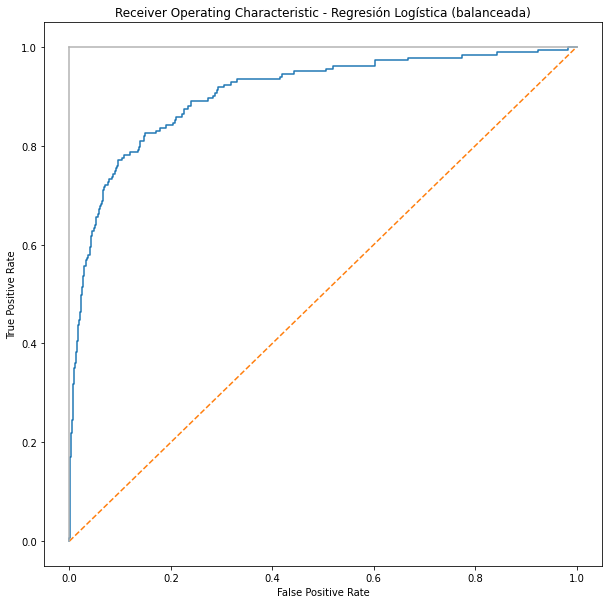

In [42]:
#Evaluación de la curva ROC.
metricas_regresionlogBAL = plotCurvaRoc(y_test, y_probability, 'Regresión Logística (balanceada)', metricas_regresionlogBAL)

In [43]:
metricas_regresionlogBAL

{'Algoritmo': 'Regresion Logistica Balanceada',
 'Accuracy': 0.8706479690522244,
 'Recall': 0.7868852459016393,
 'Precision': 0.024040066777963272,
 'True Positive': 39467,
 'False Positive': 5846,
 'False Negative': 39,
 'True Negative': 144,
 'Predict Max': 367600,
 'Predict Sum': 121000,
 'Proba de Corte': 0.871,
 'ROC': 0.905625100168482}

------

#Modelo 3: Regresión Logística CV


##Entrenamiento

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_train_std = std.fit_transform(X_train)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:

```
X_train_nf = sel.fit_transform(X_train_std, y_train))
```

###Modelado


Realizamos una validación cruzada de los datos de TRAIN para luego entrenar la regresión logística CV.

In [44]:
#Entrenamiento y validación cruzada.
RLCV_modelo_balanceado = LogisticRegressionCV(cv = 5, random_state = 0, class_weight = 'balanced')
RLCV_modelo_balanceado.fit(X_train_nf, y_train)

LogisticRegressionCV(class_weight='balanced', cv=5, random_state=0)

##Predicción

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_std = std.transform(X_test)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_nf = sel.transform(X_test_std)
```

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [45]:
# Prediccion del conjunto test
y_pred = RLCV_modelo_balanceado.predict(X_test_nf)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 1 1 ... 0 0 1]
Cantidad de 0:  39527
Cantidad de 1:  5969


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [46]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = RLCV_modelo_balanceado.predict_proba(X_test_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/RegresionLogisticaCV')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [47]:
#Evaluación de métricas.
metricas_regresionlogCV = printmetricas(y_test, y_pred, df_pred, 'Regresion Logistica CV')

---------- Test: Accuracy ----------
0.8711974679092668
---------- Test: Recall ----------
0.7978142076502732
---------- Test: Precision ----------
0.024459708493885072
--------- Confusion Matrix ---------
[[39490  5823]
 [   37   146]]
-------------------------------
Máximo posible de Ganancia:  379200
Total de Ganancia Real:  133100


--------- Curva ROC Score ---------
0.9087812891968542


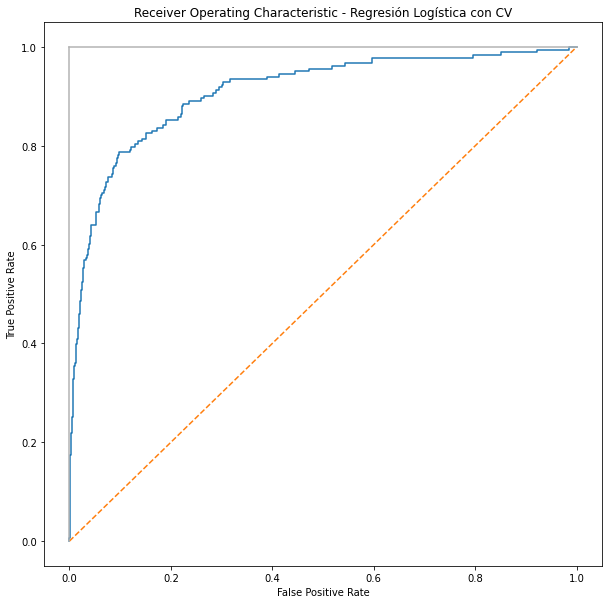

In [48]:
#Evaluación de la curva ROC.
metricas_regresionlogCV = plotCurvaRoc(y_test, y_probability, 'Regresión Logística con CV', metricas_regresionlogCV)

In [49]:
metricas_regresionlogCV

{'Algoritmo': 'Regresion Logistica CV',
 'Accuracy': 0.8711974679092668,
 'Recall': 0.7978142076502732,
 'Precision': 0.024459708493885072,
 'True Positive': 39490,
 'False Positive': 5823,
 'False Negative': 37,
 'True Negative': 146,
 'Predict Max': 379200,
 'Predict Sum': 133100,
 'Proba de Corte': 0.794,
 'ROC': 0.9087812891968542}

------

#Modelo 4: Árbol de Decisión

##Entrenamiento



###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_train_std = std.fit_transform(X_train)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:

```
X_train_nf = sel.fit_transform(X_train_std, y_train))
```

###Modelado

Realizamos una validación cruzada de los datos de TRAIN para luego entrenar el árbol de decisión.

In [50]:
#Entrenamiento con validacion cruzada.
dtc = DecisionTreeClassifier(max_depth = 5)

resultados = cross_val_score(dtc, X_train_nf , y_train, cv = KFold(n_splits = 5, shuffle = True, random_state = 42))
print('Accuracy:  %0.4f +/- %0.4f' % (resultados.mean(), resultados.std()))

DTC_modelo = dtc.fit(X_train_nf, y_train)

Accuracy:  0.9955 +/- 0.0002


##Predicción

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_std = std.transform(X_test)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_nf = sel.transform(X_test_std)
```

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [51]:
# Prediccion del conjunto test
y_pred = DTC_modelo.predict(X_test_nf)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 0 0 ... 0 0 0]
Cantidad de 0:  45444
Cantidad de 1:  52


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [52]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = DTC_modelo.predict_proba(X_test_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/ArbolDecision')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [53]:
#Evaluación de métricas.
metricas_arboldecision = printmetricas(y_test, y_pred, df_pred, 'Arbol Decision')

---------- Test: Accuracy ----------
0.9954061895551257
---------- Test: Recall ----------
0.07103825136612021
---------- Test: Precision ----------
0.25
--------- Confusion Matrix ---------
[[45274    39]
 [  170    13]]
-------------------------------
Máximo posible de Ganancia:  59800
Total de Ganancia Real:  59800


--------- Curva ROC Score ---------
0.832454322870709


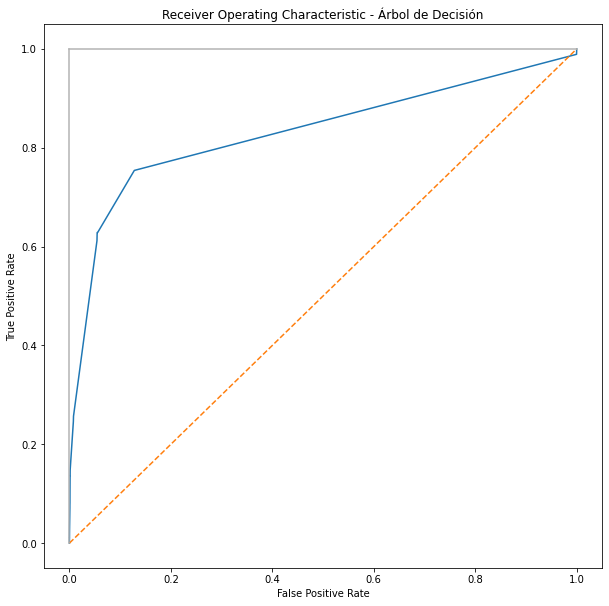

In [54]:
#Evaluación de la curva ROC.
metricas_arboldecision = plotCurvaRoc(y_test, y_probability, 'Árbol de Decisión', metricas_arboldecision)

In [55]:
metricas_arboldecision

{'Algoritmo': 'Arbol Decision',
 'Accuracy': 0.9954061895551257,
 'Recall': 0.07103825136612021,
 'Precision': 0.25,
 'True Positive': 45274,
 'False Positive': 39,
 'False Negative': 170,
 'True Negative': 13,
 'Predict Max': 59800,
 'Predict Sum': 59800,
 'Proba de Corte': 0.517,
 'ROC': 0.832454322870709}

------

#Modelo 5: Árbol de Decisión - balanceado

##Entrenamiento

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_train_std = std.fit_transform(X_train)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:

```
X_train_nf = sel.fit_transform(X_train_std, y_train))
```

###Modelado

Realizamos una validación cruzada de los datos de TRAIN para luego entrenar el árbol de decisión balanceado.

In [56]:
#Entrenamiento con validacion cruzada.
dtc = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced')

resultados = cross_val_score(dtc, X_train_nf , y_train, cv = KFold(n_splits = 5, shuffle = True, random_state = 42))
print('Accuracy:  %0.4f +/- %0.4f' % (resultados.mean(), resultados.std()))

DTC_modelo_balanceado = dtc.fit(X_train_nf, y_train)

Accuracy:  0.8685 +/- 0.0201


##Predicción

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_std = std.transform(X_test)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_nf = sel.transform(X_test_std)
```

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [57]:
# Prediccion del conjunto test
y_pred = DTC_modelo_balanceado.predict(X_test_nf)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 1 0 ... 0 0 0]
Cantidad de 0:  39861
Cantidad de 1:  5635


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [58]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = DTC_modelo_balanceado.predict_proba(X_test_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/ArbolDecision-balanceado')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [59]:
#Evaluación de métricas.
metricas_arboldecisionBAL = printmetricas(y_test, y_pred, df_pred, 'Arbol Decision Balanceado')

---------- Test: Accuracy ----------
0.878318973096536
---------- Test: Recall ----------
0.7704918032786885
---------- Test: Precision ----------
0.02502218278615794
--------- Confusion Matrix ---------
[[39819  5494]
 [   42   141]]
-------------------------------
Máximo posible de Ganancia:  298400
Total de Ganancia Real:  141500


--------- Curva ROC Score ---------
0.8499788779417576


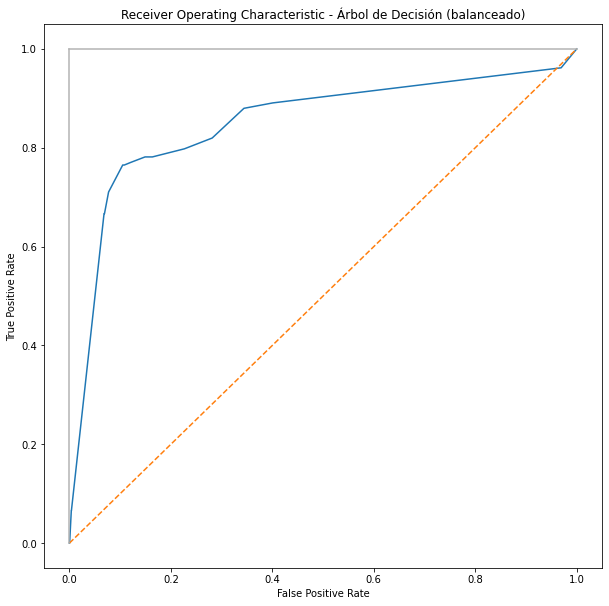

In [60]:
#Evaluación de la curva ROC.
metricas_arboldecisionBAL = plotCurvaRoc(y_test, y_probability, 'Árbol de Decisión (balanceado)', metricas_arboldecisionBAL)

In [61]:
metricas_arboldecisionBAL

{'Algoritmo': 'Arbol Decision Balanceado',
 'Accuracy': 0.878318973096536,
 'Recall': 0.7704918032786885,
 'Precision': 0.02502218278615794,
 'True Positive': 39819,
 'False Positive': 5494,
 'False Negative': 42,
 'True Negative': 141,
 'Predict Max': 298400,
 'Predict Sum': 141500,
 'Proba de Corte': 0.807,
 'ROC': 0.8499788779417576}

---------

#Modelo 6: Random Forest - balanceado

## Entrenamiento

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_train_std = std.fit_transform(X_train)
```

###Sobremuestro de datos

En este caso realizaremos un sobremuestreo de la clase minoritaria utilizando el método *smote()*.

In [62]:
#Sobremuestreo.
sobremuestreo = SMOTE()
X_train_resampled, y_train_resampled = sobremuestreo.fit_resample(X_train_std, y_train)

print('---------- y_train ---------- ')
print('Cantidad de 0: ', (y_train == 0).sum())
print('Cantidad de 1: ', (y_train == 1).sum())
print('---------- y_train_resampled ---------- ')
print('Cantidad de 0: ', (y_train_resampled == 0).sum())
print('Cantidad de 1: ', (y_train_resampled == 1).sum())

---------- y_train ---------- 
Cantidad de 0:  135895
Cantidad de 1:  590
---------- y_train_resampled ---------- 
Cantidad de 0:  135895
Cantidad de 1:  135895


###Selección de Variables y Modelado

Realizamos de manera conjunta la validación cruzada de datos de TRAIN, la selección de características y el entrenamiento del random forest balanceado.

In [63]:
#Modelado con selección de variables y validacion cruzada.
rf = RandomForestClassifier(n_estimators = 5, max_depth = 7)

rfecv = RFECV(estimator = rf, step = 7, min_features_to_select = 70, cv = StratifiedKFold(5), scoring = 'roc_auc', verbose = 1)

rfecv.fit(X_train_resampled, y_train_resampled)

Fitting estimator with 151 features.
Fitting estimator with 144 features.
Fitting estimator with 137 features.
Fitting estimator with 130 features.
Fitting estimator with 123 features.
Fitting estimator with 116 features.
Fitting estimator with 109 features.
Fitting estimator with 102 features.
Fitting estimator with 95 features.
Fitting estimator with 88 features.
Fitting estimator with 81 features.
Fitting estimator with 74 features.
Fitting estimator with 151 features.
Fitting estimator with 144 features.
Fitting estimator with 137 features.
Fitting estimator with 130 features.
Fitting estimator with 123 features.
Fitting estimator with 116 features.
Fitting estimator with 109 features.
Fitting estimator with 102 features.
Fitting estimator with 95 features.
Fitting estimator with 88 features.
Fitting estimator with 81 features.
Fitting estimator with 74 features.
Fitting estimator with 151 features.
Fitting estimator with 144 features.
Fitting estimator with 137 features.
Fitting e

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=7, n_estimators=5),
      min_features_to_select=70, scoring='roc_auc', step=7, verbose=1)

##Predicción

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_std = std.transform(X_test)
```

###Selección de Variables

No realizamos la selección de variables ya que el modelo se encarga de hacerlo.

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [64]:
# Prediccion del conjunto test
y_pred = rfecv.predict(X_test_std)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 1 1 ... 0 0 0]
Cantidad de 0:  41519
Cantidad de 1:  3977


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [65]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = rfecv.predict_proba(X_test_std)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/RandomForest-balanceado')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [66]:
#Evaluación de métricas.
metricas_randomforestBAL = printmetricas(y_test, y_pred, df_pred, 'Random Forest Balanceado')

---------- Test: Accuracy ----------
0.9142781783013891
---------- Test: Recall ----------
0.7103825136612022
---------- Test: Precision ----------
0.03268795574553684
--------- Confusion Matrix ---------
[[41466  3847]
 [   53   130]]
-------------------------------
Máximo posible de Ganancia:  341000
Total de Ganancia Real:  252300


--------- Curva ROC Score ---------
0.9073706396034191


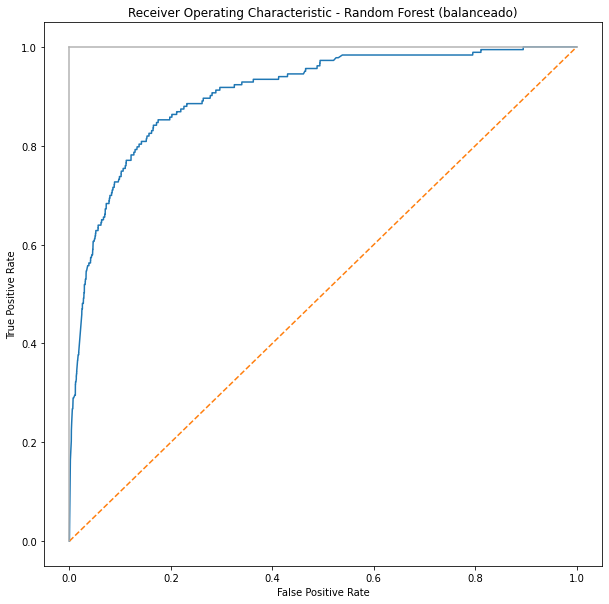

In [67]:
#Evaluación de la curva ROC.
metricas_randomforestBAL = plotCurvaRoc(y_test, y_probability, 'Random Forest (balanceado)', metricas_randomforestBAL)

In [68]:
metricas_randomforestBAL

{'Algoritmo': 'Random Forest Balanceado',
 'Accuracy': 0.9142781783013891,
 'Recall': 0.7103825136612022,
 'Precision': 0.03268795574553684,
 'True Positive': 41466,
 'False Positive': 3847,
 'False Negative': 53,
 'True Negative': 130,
 'Predict Max': 341000,
 'Predict Sum': 252300,
 'Proba de Corte': 0.776,
 'ROC': 0.9073706396034191}

-----

#Modelo 7: Random Forest - Grid Search 

##Entrenamiento

En este modelo tomaremos la estandarización y el sobremuestro de datos del conjunto TRAIN utilizados en modelo anterior.

### Optimización de hiperparámetros y modelado

Realizamos en conjunto la optimización de hiperparámetros para un random forest con el método *GridSearchCV()* y el modelado del mismo.


In [69]:
#GridSerch para optimizar hiperparámetros
rf_gs = RandomForestClassifier(n_estimators = 5)

parameters = { 
    'max_depth': [5, 7],
    'max_features': ['auto', 'sqrt', 'log2']
}

clf_grid = GridSearchCV(rf_gs, parameters, n_jobs = -1)
clf_grid.fit(X_train_resampled, y_train_resampled)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=5), n_jobs=-1,
             param_grid={'max_depth': [5, 7],
                         'max_features': ['auto', 'sqrt', 'log2']})

In [70]:
clf_grid.score(X_train_resampled, y_train_resampled)

0.9223922881636558

In [71]:
clf_grid.best_params_

{'max_depth': 7, 'max_features': 'auto'}

##Predicción

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST

In [72]:
y_pred = clf_grid.predict(X_test_std)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 1 1 ... 0 0 0]
Cantidad de 0:  40919
Cantidad de 1:  4577


###Descarga de datos
Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [73]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = clf_grid.predict_proba(X_test_std)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/RandomForestGridSearch')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [74]:
#Evaluación de métricas.
metricas_randomforestGS = printmetricas(y_test, y_pred, df_pred, 'Random Forest Grid Search')

---------- Test: Accuracy ----------
0.9014418850008792
---------- Test: Recall ----------
0.7540983606557377
---------- Test: Precision ----------
0.03015075376884422
--------- Confusion Matrix ---------
[[40874  4439]
 [   45   138]]
-------------------------------
Máximo posible de Ganancia:  360500
Total de Ganancia Real:  232300


--------- Curva ROC Score ---------
0.900448718621262


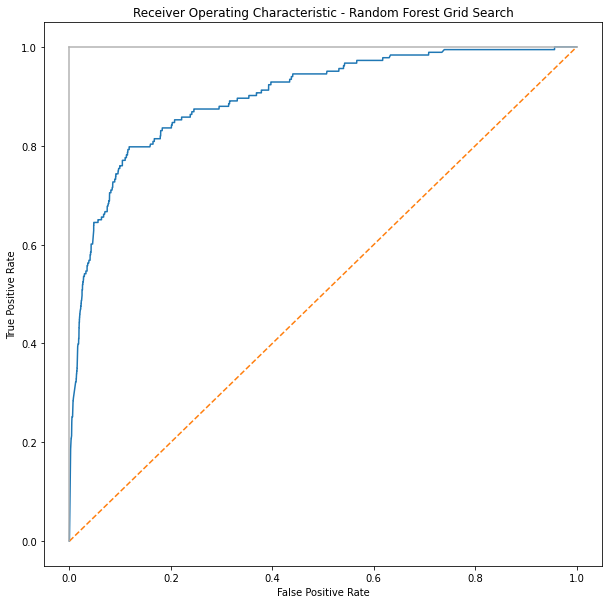

In [75]:
#Evaluación de la curva ROC.
metricas_randomforestGS = plotCurvaRoc(y_test, y_probability, 'Random Forest Grid Search', metricas_randomforestGS)

In [76]:
metricas_randomforestGS

{'Algoritmo': 'Random Forest Grid Search',
 'Accuracy': 0.9014418850008792,
 'Recall': 0.7540983606557377,
 'Precision': 0.03015075376884422,
 'True Positive': 40874,
 'False Positive': 4439,
 'False Negative': 45,
 'True Negative': 138,
 'Predict Max': 360500,
 'Predict Sum': 232300,
 'Proba de Corte': 0.661,
 'ROC': 0.900448718621262}

-----

#Modelo 8: Gradient Boosting

##Entrenamiento

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_train_std = std.fit_transform(X_train)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:

```
X_train_nf = sel.fit_transform(X_train_std, y_train))
```

###Modelado

Realizamos el entrenamiento del gradient boosting classifier con los datos de TRAIN.

In [77]:
#Entrenamiento
gbc = GradientBoostingClassifier(n_estimators = 50)
GBC_modelo = gbc.fit(X_train_nf, y_train)

##Predicción

###Estandarización

Utilizamos la misma estandarización que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_std = std.transform(X_test)
```

###Selección de Variables

Utilizamos la misma selección de variables que para el MODELO 1 - Regresión Logística.

El código utilizado es el siguiente:
```
X_test_nf = sel.transform(X_test_std)
```

###Predicción del conjunto test

Realizamos la predicción de clases sobre los datos del conjunto TEST.

In [78]:
y_pred = GBC_modelo.predict(X_test_nf)

print('---------- y_pred ---------- ')
print(y_pred)
print('Cantidad de 0: ', (y_pred == 0).sum())
print('Cantidad de 1: ', (y_pred == 1).sum())

---------- y_pred ---------- 
[0 0 0 ... 0 0 0]
Cantidad de 0:  45450
Cantidad de 1:  46


###Descarga de datos

Descargamos los datos en un archivo CSV para utilizar luego en la comparación de modelos.

In [79]:
#Clase Real, Clase Predicha y Probabilidad Asociada
y_probability = GBC_modelo.predict_proba(X_test_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": y_test, "y_pred": y_pred,"prob_a": y_probability})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/GradientBoosting')

###Evaluación del modelo

Procedemos a calcular diferentes métricas sobre las predicciones del modelo.

In [80]:
#Evaluación de métricas.
metricas_gradientboosting = printmetricas(y_test, y_pred, df_pred, 'Gradient Boosting')

---------- Test: Accuracy ----------
0.9954941093722525
---------- Test: Recall ----------
0.06557377049180328
---------- Test: Precision ----------
0.2608695652173913
--------- Confusion Matrix ---------
[[45279    34]
 [  171    12]]
-------------------------------
Máximo posible de Ganancia:  55400
Total de Ganancia Real:  55400


--------- Curva ROC Score ---------
0.89932001805535


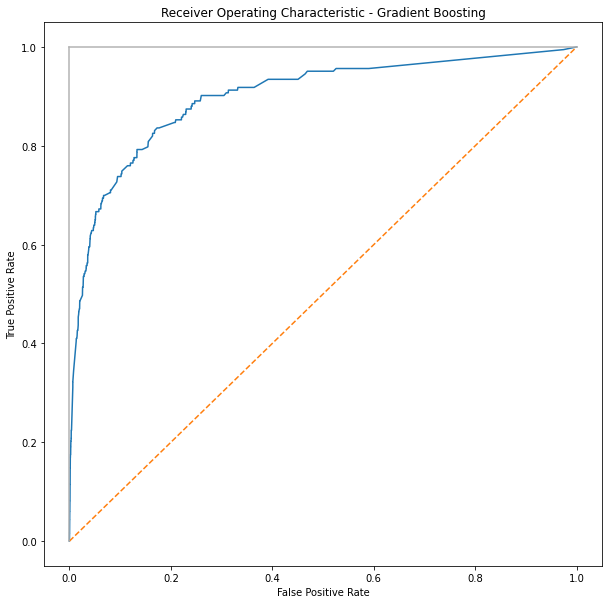

In [81]:
#Evaluación de la curva ROC.
metricas_gradientboosting = plotCurvaRoc(y_test, y_probability, 'Gradient Boosting', metricas_gradientboosting)

In [82]:
metricas_gradientboosting

{'Algoritmo': 'Gradient Boosting',
 'Accuracy': 0.9954941093722525,
 'Recall': 0.06557377049180328,
 'Precision': 0.2608695652173913,
 'True Positive': 45279,
 'False Positive': 34,
 'False Negative': 171,
 'True Negative': 12,
 'Predict Max': 55400,
 'Predict Sum': 55400,
 'Proba de Corte': 0.501,
 'ROC': 0.89932001805535}

------

#Comparación de modelos

Una vez entrenados todos los modelos predictivos propuestos para la problemática planteada, procedemos a comprar las métricas obtenidas para cada uno de ellos.

Dado que para Banco Camila el costo de envío del paquete de beneficios tiene un valor de USD 100, y que el monto ganado por retener a un cliente con potencial de baja es de USD 5000, calculamos:

- La predicción máxima de ingresos (*predict max*): indica el monto máximo de ganancia que puede obtener el banco tras la detección de clientes con potencial de baja.
- La predicción acumulada (*predict sum*): indica el monto acumulado del banco en caso de accionar con todos los cliente que se predijeron como potenciales bajas.

Haciendo foco en la máximización de las ganancias por parte de nuestro cliente, se identificó la probabilidad de corte (*proba de corte*) para cada modelo donde la ganancia sea la mayor posible. De esta forma, los clientes predichos como potenciales bajas con probabilidad igual o mayor a dicho corte serán quienes deben recibir el paquete de beneficios.


In [83]:
comparaciones = [metricas_regresionlog, metricas_regresionlogBAL, metricas_regresionlogCV,
                 metricas_arboldecision, metricas_arboldecisionBAL,
                 metricas_randomforestBAL, metricas_randomforestGS,
                 metricas_gradientboosting]
                 
df_comparacion = pd.DataFrame(comparaciones)
df_comparacion.sort_values(by = ['Predict Max'], ascending = False)

,Algoritmo,Accuracy,Recall,Precision,True Positive,False Positive,False Negative,True Negative,Predict Max,Predict Sum,Proba de Corte,ROC
2,Regresion Logistica CV,0.871197,0.797814,0.024460,39490,5823,37,146,379200,133100,0.794,0.908781
1,Regresion Logistica Balanceada,0.870648,0.786885,0.024040,39467,5846,39,144,367600,121000,0.871,0.905625
6,Random Forest Grid Search,0.901442,0.754098,0.030151,40874,4439,45,138,360500,232300,0.661,0.900449
5,Random Forest Balanceado,0.914278,0.710383,0.032688,41466,3847,53,130,341000,252300,0.776,0.907371
4,Arbol Decision Balanceado,0.878319,0.770492,0.025022,39819,5494,42,141,298400,141500,0.807,0.849979
3,Arbol Decision,0.995406,0.071038,0.250000,45274,39,170,13,59800,59800,0.517,0.832454
7,Gradient Boosting,0.995494,0.065574,0.260870,45279,34,171,12,55400,55400,0.501,0.899320
0,Regresion Logistica,0.995934,0.038251,0.437500,45304,9,176,7,33400,33400,0.502,0.914161


------

#Modelo predictivo seleccionado

Tomando en consideración la comparación anterior centrada en la maximización de ganancias, el modelo que mejor se ajusta a esta regla de negocio es la **Regresión Logistica CV**.

Este modelo estima una ganancia de USD 379200 para el dataset utilizado durante el entrenamiento del mismo, lo cual es considerablemente mayor en relación a los otros modelos analizados, con una probabilidad de corte de 0.794.

------

#Validación con nuevo dataset

Una vez seleccionado el modelo predictivo para la identificación de clientes con potencial de baja, procedemos a validarlo con otros datos provenientes del dataset original. 

Para la validación se analizarán los meses de Mayo, Junio y Julio de 2013 (201305, 201306 y 201307) dado que contamos con la información completa de clientes que se dieron de baja en Julio de 2013.

Los pasos siguientes corresponden nuevamente a la limpieza y transformación de datos, generación de la variable objetivo y predicción de la misma utilizando exclusivamente el modelo escogido.

Buscamos con esto encontrar un valor similar para la probabilidad de corte optimizando la ganancia del cliente. 

##Carga de datos

In [84]:
df_validacion = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Bimestre3/MESES_201305_201307.parquet')


##Limpieza y trasformación

In [85]:
df_validacion = df_validacion[variables_mandatorias]
df_validacion

,numero_de_cliente,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,marketing_coss_selling,tpaquete2,tpaquete4,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo,foto_mes
13,5609788,0,224,61,228,1512.28,6908.34,8,N,N,...,20130502,37601.63,-43860.62,5530.8,19970317,15436.06,S,S,20556.9,201305
14,5609788,0,224,61,229,1184.84,7835.38,8,N,N,...,20130627,0,-37639.85,4960.76,19970317,10622.9,S,S,10670.4,201306
15,5609788,0,224,61,230,992.46,8558.35,8,N,N,...,20130801,0,-23813.71,2563.99,19970317,2484.99,S,N,1485.9,201307
29,5609981,0,227,64,187,497.75,5385.53,10,N,N,...,20130502,1427.4,-1310.4,0,20010308,970.11,S,N,1427.4,201305
30,5609981,0,227,64,188,702.10,5834.27,9,N,N,...,20130627,0,-16078.14,0,20010308,899.71,S,N,0,201306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688565,46912175,0,1457,44,1,643.85,643.85,7,N,N,...,20130801,0,.,.,20130724,.,S,S,0,201307
2688575,46913533,0,155,35,1,128.17,128.17,6,N,N,...,20130801,0,.,.,20130715,.,S,S,0,201307
2688585,46914182,0,677,24,1,2471.23,2471.23,7,N,N,...,20130725,0,0,0,20130704,0,N,N,386.1,201307
2688590,46916366,0,1184,44,1,39.39,39.39,6,N,N,...,20130725,0,.,.,20130723,.,S,S,0,201307


In [86]:
#Análisis de duplicados.
df_validacion_T = df_validacion.groupby(['numero_de_cliente','foto_mes'])['numero_de_cliente'].count().reset_index(name='count')  
df_validacion_T[df_validacion_T['count']>1]

,numero_de_cliente,foto_mes,count


In [87]:
#Generacion de columnas con informacion de mes+1 y mes+2.
df_validacion['Mes_1'] = df_validacion.groupby(['numero_de_cliente'])['foto_mes'].shift(-1)
df_validacion['Mes_2'] = df_validacion.groupby(['numero_de_cliente'])['foto_mes'].shift(-2)

#Eliminacion de los registros con fecha > a 201402.

df_validacion = df_validacion[df_validacion.foto_mes == 201305]


In [88]:
#Generacion de columnas target como clase y binaria.
df_validacion['target'] = "Baja+1"

df_validacion.loc[(df_validacion['Mes_1'] ==201306), 'target'] = "Baja+2"
df_validacion.loc[(df_validacion['Mes_2'] ==201307), 'target'] = "Continua"

df_validacion['target_bin'] = np.where(df_validacion['target']=='Baja+2', 1, 0)

df_validacion['target_bin'].value_counts()

0    161153
1       567
Name: target_bin, dtype: int64

In [89]:
#Eliminacion de las columnas auxiliares temporales.
df_validacion = df_validacion.drop(['Mes_1' , 'Mes_2', 'target'] , axis = 'columns')

In [90]:
#Eliminación de columnas sin valor comercial.
columnas_del = ['numero_de_cliente', 'Master_Fvencimiento', 'Master_fultimo_cierre', 'Master_fechaalta', 'Visa_Fvencimiento', 'Visa_fultimo_cierre', 'Visa_fechaalta', 'foto_mes']
df_validacion.drop(columns = columnas_del, axis = 1, inplace = True)
df_validacion.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161720 entries, 13 to 2686169
Data columns (total 139 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    cliente_vip                       int64  
 1    cliente_sucursal                  int64  
 2    cliente_edad                      int64  
 3    cliente_antiguedad                int64  
 4    mrentabilidad                     float64
 5    mrentabilidad_annual              float64
 6    marketing_coss_selling            int64  
 7    tpaquete2                         object 
 8    tpaquete4                         object 
 9    tpaquete6                         object 
 10   tpaquete7                         object 
 11   tpaquete9                         object 
 12   tcuentas                          object 
 13   tcuenta_corriente                 object 
 14   mcuenta_corriente_Nopaquete       float64
 15   mcuenta_corriente_Paquete         float64
 16   tcaja_ahorro    

In [91]:
#Reemplazo de '.' por -1, y trasformación a tipo INT
df_validacion['Visa_marca_atraso'] = df_validacion['Visa_marca_atraso'].replace('.', -1).astype(int)
df_validacion['Master_marca_atraso'] = df_validacion['Master_marca_atraso'].replace('.', -1).astype(int)

In [92]:
#Reemplazo de '.' por 0, y transformación a tipo FLOAT
columnas_float = ['mprestamos_hipotecarios', 'mcuenta_debitos_automaticos', 'mttarjeta_visa_debitos_automatic', 'mttarjeta_master_debitos_automat', 'mpagodeservicios',
'mpagomiscuentas', 'mtarjeta_visa_descuentos', 'mtarjeta_master_descuentos', 'Master_mfinanciacion_limite', 'Master_msaldototal', 'Master_msaldopesos', 'Master_msaldodolares',
'Master_mconsumospesos', 'Master_mconsumosdolares', 'Master_mlimitecompra', 'Master_madelantopesos', 'Master_madelantodolares', 'Master_mpagado', 'Master_mpagospesos', 'Master_mpagosdolares',
'Master_mconsumototal', 'Master_mpagominimo', 'Visa_mfinanciacion_limite', 'Visa_msaldototal', 'Visa_msaldopesos', 'Visa_msaldodolares', 'Visa_mconsumospesos', 'Visa_mconsumosdolares', 
'Visa_mlimitecompra', 'Visa_madelantopesos', 'Visa_madelantodolares', 'Visa_mpagado', 'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_mconsumototal', 'Visa_mpagominimo']

for col in columnas_float:
  df_validacion[col] = df_validacion[col].replace('.', 0).astype(float)

In [93]:
#Variables con más de dos posibles valores.
df_validacion = pd.get_dummies(df_validacion, columns = ['Master_cuenta_estado', 'Visa_cuenta_estado'])

In [94]:
#Variables con solo dos valores posibles.
columnas_dummies = ['tpaquete2', 'tpaquete4', 'tpaquete6', 'tpaquete7', 'tpaquete9', 'tcuentas', 'tcuenta_corriente', 'tcaja_ahorro', 'ttarjeta_debito', 'ttarjeta_visa', 
'ttarjeta_master', 'tplazo_fijo', 'tfondos_comunes_inversion', 'ttitulos', 'tseguro_vida_mercado_abierto', 'tseguro_auto', 'tseguro_vivienda', 'tseguro_accidentes_personales', 
'tcaja_seguridad',  'tcuenta_debitos_automaticos', 'ttarjeta_visa_debitos_automatico', 'ttarjeta_master_debitos_automati', 'tpagodeservicios','tpagomiscuentas', 'tcambio_monedas', 
'tcallcenter',  'tcajas', 'tcajas_depositos', 'tcajas_extracciones', 'tcajas_otras', 'tmovimientos_ultimos90dias', 'Master_tconsumos', 'Master_tadelantosefectivo', 
'Visa_tconsumos', 'Visa_tadelantosefectivo']

df_validacion = pd.get_dummies(df_validacion, columns = columnas_dummies, drop_first = True)
df_validacion.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161720 entries, 13 to 2686169
Data columns (total 147 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    cliente_vip                         int64  
 1    cliente_sucursal                    int64  
 2    cliente_edad                        int64  
 3    cliente_antiguedad                  int64  
 4    mrentabilidad                       float64
 5    mrentabilidad_annual                float64
 6    marketing_coss_selling              int64  
 7    mcuenta_corriente_Nopaquete         float64
 8    mcuenta_corriente_Paquete           float64
 9    mcaja_ahorro_Paquete                float64
 10   mcaja_ahorro_Nopaquete              float64
 11   mcaja_ahorro_dolares                float64
 12   mdescubierto_preacordado            float64
 13   mcuentas_saldo                      float64
 14   ctarjeta_debito_transacciones       int64  
 15   mautoservicio                 

In [95]:
#Tratamiento de nulos
df_validacion = df_validacion.fillna(0)

In [96]:
#Variables calculadas
df_validacion['mcuenta_corriente_all'] = df_validacion['mcuenta_corriente_Paquete'] + df_validacion['mcuenta_corriente_Nopaquete']
df_validacion['mcaja_ahorro_all'] = df_validacion['mcaja_ahorro_Paquete'] + df_validacion['mcaja_ahorro_Nopaquete']
df_validacion['mcaja_ahorro_CC'] = df_validacion['mcaja_ahorro_all'] + df_validacion['mcuenta_corriente_all']
df_validacion['mtarjeta_all_consumo'] = df_validacion['mtarjeta_visa_consumo'] + df_validacion['mtarjeta_master_consumo']
df_validacion['ctarjeta_all_transacciones'] = df_validacion['ctarjeta_visa_transacciones'] + df_validacion['ctarjeta_master_transacciones']

In [97]:
df_validacion.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161720 entries, 13 to 2686169
Data columns (total 152 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    cliente_vip                         int64  
 1    cliente_sucursal                    int64  
 2    cliente_edad                        int64  
 3    cliente_antiguedad                  int64  
 4    mrentabilidad                       float64
 5    mrentabilidad_annual                float64
 6    marketing_coss_selling              int64  
 7    mcuenta_corriente_Nopaquete         float64
 8    mcuenta_corriente_Paquete           float64
 9    mcaja_ahorro_Paquete                float64
 10   mcaja_ahorro_Nopaquete              float64
 11   mcaja_ahorro_dolares                float64
 12   mdescubierto_preacordado            float64
 13   mcuentas_saldo                      float64
 14   ctarjeta_debito_transacciones       int64  
 15   mautoservicio                 

##Separación de los datos

In [98]:
#Separación.
X_validacion = df_validacion.drop(['target_bin'] , axis = 'columns')
Y_validacion = df_validacion.target_bin

##Estandarización

In [99]:
X_validacion_std = std.transform(X_validacion)

##Selección de Variables

In [100]:
X_validacion_nf = sel.transform(X_validacion_std)

##Predicción

In [101]:
y_pred_validacion = RLCV_modelo_balanceado.predict(X_validacion_nf)

print('---------- y_pred ---------- ')
print(y_pred_validacion)
print('Cantidad de 0: ', (y_pred_validacion == 0).sum())
print('Cantidad de 1: ', (y_pred_validacion == 1).sum())

---------- y_pred ---------- 
[0 0 0 ... 1 1 0]
Cantidad de 0:  141910
Cantidad de 1:  19810


##Descarga de datos

In [102]:
# Clase Real, Clase Predicha y Probabilidad Asociada
y_probability_validacion = RLCV_modelo_balanceado.predict_proba(X_validacion_nf)[:, 1]

df_pred = pd.DataFrame({"y_test": Y_validacion, "y_pred": y_pred_validacion,"prob_a": y_probability_validacion})
df_pred = GuardarMetricasCSV(df_pred,'/content/drive/MyDrive/Colab Notebooks/Bimestre3/Validacion')

##Evaluación del modelo

In [103]:
#Evaluación de métricas.
metricas_validacion = printmetricas(Y_validacion, y_pred_validacion, df_pred, 'Validacion')

---------- Test: Accuracy ----------
0.8796500123670542
---------- Test: Recall ----------
0.8059964726631393
---------- Test: Precision ----------
0.023069156991418475
--------- Confusion Matrix ---------
[[141800  19353]
 [   110    457]]
-------------------------------
Máximo posible de Ganancia:  1218300
Total de Ganancia Real:  304000


--------- Curva ROC Score ---------
0.9110500782659124


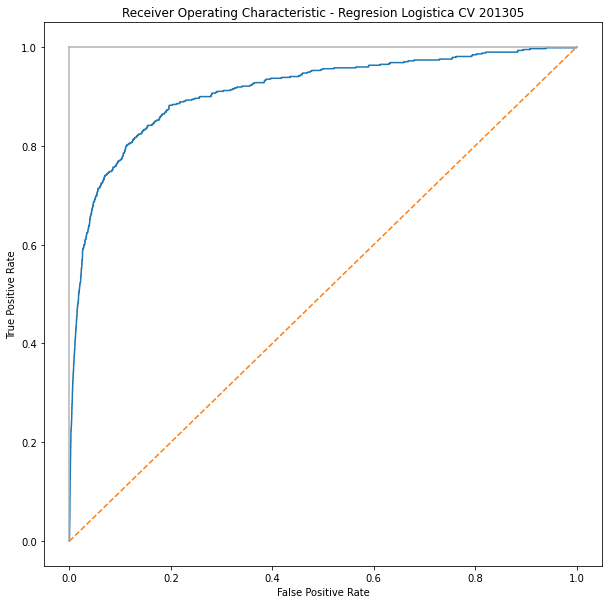

In [104]:
#Evaluación de la curva ROC.
metricas_validacion = plotCurvaRoc(Y_validacion, y_probability_validacion, 'Regresion Logistica CV 201305', metricas_validacion)

In [105]:
metricas_validacion

{'Algoritmo': 'Validacion',
 'Accuracy': 0.8796500123670542,
 'Recall': 0.8059964726631393,
 'Precision': 0.023069156991418475,
 'True Positive': 141800,
 'False Positive': 19353,
 'False Negative': 110,
 'True Negative': 457,
 'Predict Max': 1218300,
 'Predict Sum': 304000,
 'Proba de Corte': 0.848,
 'ROC': 0.9110500782659124}

In [106]:
df_conclusion = pd.DataFrame([metricas_regresionlogCV, metricas_validacion])
df_conclusion.sort_values(by = ['Predict Max'], ascending = False)

,Algoritmo,Accuracy,Recall,Precision,True Positive,False Positive,False Negative,True Negative,Predict Max,Predict Sum,Proba de Corte,ROC
1,Validacion,0.879650,0.805996,0.023069,141800,19353,110,457,1218300,304000,0.848,0.911050
0,Regresion Logistica CV,0.871197,0.797814,0.024460,39490,5823,37,146,379200,133100,0.794,0.908781


-----

#Conclusiones

Recibimos una solicitud de Banco Camila para desarrollar un modelo predictivo que estime, en base a diferentes variables financieras y crediticias, la probabilidad de que un cliente solicite la baja dentro de los próximos dos meses respecto del momento del análisis.

Para resolver esta problemática, entrenamos ocho modelos predictivos de clasificación diferentes con los datos proporcionados por el banco, para identificar aquellos clientes que deberían recibir el paquete de beneficios en el corto plazo.

El modelo que maximiza la ganancia respetando la predicción de potencial baja para un cliente fue la **Regresión Logística CV**. Con este modelo todos aquellos clientes que presenten una probabilidad mayor o igual a 0.794 de ser clase 1 (potencial baja) serán foco de esta acción de retención. 

La validación de este modelo determinó una probabilidad de corte de 0.848, lo cual representa sólo una diferencia del 0.054 de probabilidad. Por lo tanto, nos encontramos en condiciones de optar definitivamente por la Regresión Logística CV.



---------

#Predicción del mes de interés

Finalmente, procederemos a utilizar el modelo escogido para evaluar a los clientes activos en Abril de 2014 (201404) y estimar su potencial de baja para el mes de Junio de 2014.

##Carga de datos

In [107]:
df_prediccion = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Bimestre3/MES_201404.parquet')


##Limpieza y transformación

In [108]:
df_prediccion = df_prediccion[variables_mandatorias]
df_prediccion

,numero_de_cliente,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,marketing_coss_selling,tpaquete2,tpaquete4,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo,foto_mes
7,3333,0,455,0,0,-1351755.68,-1.069960e+07,0,N,N,...,.,.,.,.,.,.,S,S,.,201404
8,3333,0,455,0,0,2451895.62,-1.524554e+08,0,N,N,...,.,.,.,.,.,.,S,S,.,201404
24,5609788,0,224,62,239,-83.11,8.931040e+03,9,N,N,...,20140430,0,-5412.65,0,19970317,266.8,S,N,3954.6,201404
40,5609981,0,227,65,198,379.81,4.411550e+03,9,N,N,...,20140430,0,-8795.27,0,20010308,776.88,S,N,0,201404
56,5610023,0,536,41,93,491.06,6.913570e+03,9,N,N,...,20140430,0,-6901.64,0,20060802,708.2,S,N,3077.1,201404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694625,48914938,0,161,41,1,0.00,0.000000e+00,1,N,N,...,.,.,.,.,.,.,S,S,.,201404
2694626,48915521,0,1457,59,1,33.71,3.371000e+01,6,N,N,...,20140430,0,.,.,20140424,.,S,S,0,201404
2694627,48922297,0,2,61,1,15.97,1.597000e+01,7,N,N,...,20140424,0,.,.,20140421,.,S,S,0,201404
2694628,48926901,0,497,22,1,0.00,0.000000e+00,4,N,N,...,.,.,.,.,.,.,S,S,.,201404


In [109]:
#Análisis de duplicados.
df_prediccion_T = df_prediccion.groupby(['numero_de_cliente','foto_mes'])['numero_de_cliente'].count().reset_index(name='count')  
df_prediccion_T[df_prediccion_T['count']>1]

,numero_de_cliente,foto_mes,count
0,3333,201404,2


In [110]:
#Eliminación de duplicados.
df_prediccion = df_prediccion[df_prediccion['numero_de_cliente'] != 3333]

In [111]:
#Captura de ID de Cliente
df_lista_clientes=pd.DataFrame(df_prediccion['numero_de_cliente'])

In [112]:
#Eliminación de columnas sin valor comercial.
columnas_del = ['numero_de_cliente', 'Master_Fvencimiento', 'Master_fultimo_cierre', 'Master_fechaalta', 'Visa_Fvencimiento', 'Visa_fultimo_cierre', 'Visa_fechaalta', 'foto_mes']
df_prediccion.drop(columns = columnas_del, axis = 1, inplace = True)
df_prediccion.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184539 entries, 24 to 2694629
Data columns (total 138 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    cliente_vip                       int64  
 1    cliente_sucursal                  int64  
 2    cliente_edad                      int64  
 3    cliente_antiguedad                int64  
 4    mrentabilidad                     float64
 5    mrentabilidad_annual              float64
 6    marketing_coss_selling            int64  
 7    tpaquete2                         object 
 8    tpaquete4                         object 
 9    tpaquete6                         object 
 10   tpaquete7                         object 
 11   tpaquete9                         object 
 12   tcuentas                          object 
 13   tcuenta_corriente                 object 
 14   mcuenta_corriente_Nopaquete       float64
 15   mcuenta_corriente_Paquete         float64
 16   tcaja_ahorro    

In [113]:
#Reemplazo de '.' por -1, y trasformación a tipo INT
df_prediccion['Visa_marca_atraso'] = df_prediccion['Visa_marca_atraso'].replace('.', -1).astype(int)
df_prediccion['Master_marca_atraso'] = df_prediccion['Master_marca_atraso'].replace('.', -1).astype(int)

In [114]:
#Reemplazo de '.' por 0, y transformación a tipo FLOAT
columnas_float = ['mprestamos_hipotecarios', 'mcuenta_debitos_automaticos', 'mttarjeta_visa_debitos_automatic', 'mttarjeta_master_debitos_automat', 'mpagodeservicios',
'mpagomiscuentas', 'mtarjeta_visa_descuentos', 'mtarjeta_master_descuentos', 'Master_mfinanciacion_limite', 'Master_msaldototal', 'Master_msaldopesos', 'Master_msaldodolares',
'Master_mconsumospesos', 'Master_mconsumosdolares', 'Master_mlimitecompra', 'Master_madelantopesos', 'Master_madelantodolares', 'Master_mpagado', 'Master_mpagospesos', 'Master_mpagosdolares',
'Master_mconsumototal', 'Master_mpagominimo', 'Visa_mfinanciacion_limite', 'Visa_msaldototal', 'Visa_msaldopesos', 'Visa_msaldodolares', 'Visa_mconsumospesos', 'Visa_mconsumosdolares', 
'Visa_mlimitecompra', 'Visa_madelantopesos', 'Visa_madelantodolares', 'Visa_mpagado', 'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_mconsumototal', 'Visa_mpagominimo']

for col in columnas_float:
  df_prediccion[col] = df_prediccion[col].replace('.', 0).astype(float)

In [115]:
#Variables con más de dos posibles valores.
df_prediccion = pd.get_dummies(df_prediccion, columns = ['Master_cuenta_estado', 'Visa_cuenta_estado'])

In [116]:
#Variables con solo dos valores posibles.
columnas_dummies = ['tpaquete2', 'tpaquete4', 'tpaquete6', 'tpaquete7', 'tpaquete9', 'tcuentas', 'tcuenta_corriente', 'tcaja_ahorro', 'ttarjeta_debito', 'ttarjeta_visa', 
'ttarjeta_master', 'tplazo_fijo', 'tfondos_comunes_inversion', 'ttitulos', 'tseguro_vida_mercado_abierto', 'tseguro_auto', 'tseguro_vivienda', 'tseguro_accidentes_personales', 
'tcaja_seguridad',  'tcuenta_debitos_automaticos', 'ttarjeta_visa_debitos_automatico', 'ttarjeta_master_debitos_automati', 'tpagodeservicios','tpagomiscuentas', 'tcambio_monedas', 
'tcallcenter',  'tcajas', 'tcajas_depositos', 'tcajas_extracciones', 'tcajas_otras', 'tmovimientos_ultimos90dias', 'Master_tconsumos', 'Master_tadelantosefectivo', 
'Visa_tconsumos', 'Visa_tadelantosefectivo']

df_prediccion = pd.get_dummies(df_prediccion, columns = columnas_dummies, drop_first = True)
df_prediccion.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184539 entries, 24 to 2694629
Data columns (total 146 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    cliente_vip                         int64  
 1    cliente_sucursal                    int64  
 2    cliente_edad                        int64  
 3    cliente_antiguedad                  int64  
 4    mrentabilidad                       float64
 5    mrentabilidad_annual                float64
 6    marketing_coss_selling              int64  
 7    mcuenta_corriente_Nopaquete         float64
 8    mcuenta_corriente_Paquete           float64
 9    mcaja_ahorro_Paquete                float64
 10   mcaja_ahorro_Nopaquete              float64
 11   mcaja_ahorro_dolares                float64
 12   mdescubierto_preacordado            float64
 13   mcuentas_saldo                      float64
 14   ctarjeta_debito_transacciones       int64  
 15   mautoservicio                 

In [117]:
#Tratamiento de nulos
df_prediccion = df_prediccion.fillna(0)

In [118]:
#Variables calculadas
df_prediccion['mcuenta_corriente_all'] = df_prediccion['mcuenta_corriente_Paquete'] + df_prediccion['mcuenta_corriente_Nopaquete']
df_prediccion['mcaja_ahorro_all'] = df_prediccion['mcaja_ahorro_Paquete'] + df_prediccion['mcaja_ahorro_Nopaquete']
df_prediccion['mcaja_ahorro_CC'] = df_prediccion['mcaja_ahorro_all'] + df_prediccion['mcuenta_corriente_all']
df_prediccion['mtarjeta_all_consumo'] = df_prediccion['mtarjeta_visa_consumo'] + df_prediccion['mtarjeta_master_consumo']
df_prediccion['ctarjeta_all_transacciones'] = df_prediccion['ctarjeta_visa_transacciones'] + df_prediccion['ctarjeta_master_transacciones']

In [119]:
df_prediccion.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184539 entries, 24 to 2694629
Data columns (total 151 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    cliente_vip                         int64  
 1    cliente_sucursal                    int64  
 2    cliente_edad                        int64  
 3    cliente_antiguedad                  int64  
 4    mrentabilidad                       float64
 5    mrentabilidad_annual                float64
 6    marketing_coss_selling              int64  
 7    mcuenta_corriente_Nopaquete         float64
 8    mcuenta_corriente_Paquete           float64
 9    mcaja_ahorro_Paquete                float64
 10   mcaja_ahorro_Nopaquete              float64
 11   mcaja_ahorro_dolares                float64
 12   mdescubierto_preacordado            float64
 13   mcuentas_saldo                      float64
 14   ctarjeta_debito_transacciones       int64  
 15   mautoservicio                 

##Predicción

In [120]:
#Estandarización de features
X_prediccion_std = std.transform(df_prediccion)

In [121]:
#Selección de características
X_prediccion_nf = sel.transform(X_prediccion_std)

In [122]:
#Prediccion utilizando Regresión Logistica CV
y_pred_prediccion = RLCV_modelo_balanceado.predict(X_prediccion_nf)

print('---------- y_pred ---------- ')
print(y_pred_prediccion)
print('Cantidad de 0: ', (y_pred_prediccion == 0).sum())
print('Cantidad de 1: ', (y_pred_prediccion == 1).sum())

---------- y_pred ---------- 
[0 1 0 ... 1 1 1]
Cantidad de 0:  158556
Cantidad de 1:  25983


##Filtrado por probabilidad

In [123]:
#Unificacion de cliente y predicción
df_lista_clientes['prediccion']=y_pred_prediccion
df_lista_clientes

,numero_de_cliente,prediccion
24,5609788,0
40,5609981,1
56,5610023,0
72,5610089,0
88,5610101,0
...,...,...
2694625,48914938,1
2694626,48915521,1
2694627,48922297,1
2694628,48926901,1


In [124]:
#Calculo de probabilidad
y_pred_prediccion_probability=RLCV_modelo_balanceado.predict_proba(X_prediccion_nf)[:,1]

In [125]:
#Unificacion de probabilidad y ordenamiento ascendente
df_lista_clientes['prob_a']=y_pred_prediccion_probability
df_lista_clientes=df_lista_clientes.sort_values(by='prob_a',ascending=False)
df_lista_clientes

,numero_de_cliente,prediccion,prob_a
581672,9438634,1,1.000000e+00
683815,10112531,1,1.000000e+00
2153911,29880976,1,9.999999e-01
2680769,46049827,1,9.999998e-01
1924934,26387234,1,9.999998e-01
...,...,...,...
742362,10502410,0,7.019533e-40
45257,5928997,0,3.331784e-41
77932,6134577,0,1.091250e-43
484769,8781620,0,3.135274e-44


In [126]:
#Filtrado por probabilidad de corte
df_lista_clientes_filtrado=df_lista_clientes[df_lista_clientes.prob_a>0.794].reset_index(drop=True)
df_lista_clientes_filtrado

,numero_de_cliente,prediccion,prob_a
0,9438634,1,1.000000
1,10112531,1,1.000000
2,29880976,1,1.000000
3,46049827,1,1.000000
4,26387234,1,1.000000
...,...,...,...
8507,28030119,1,0.794084
8508,27649691,1,0.794031
8509,21946347,1,0.794018
8510,26808865,1,0.794007


##Entrega de predicciones
Tal lo comprometido en el contrato original, entregamos a Banco Camila el archivo CSV con las predicciones de clientes con baja potencial en Junio 2014 al solo hecho que pueda ser utilizado para generar la campaña de beneficios que consideren oportuna. 

In [127]:
#Guardado de clientes pósitivos en archivo CSV

df_lista_clientes_filtrado.to_csv('/content/drive/MyDrive/Colab Notebooks/Bimestre3/Pred_Bco_Camila_201404.csv')